# 自注意力 self-attention

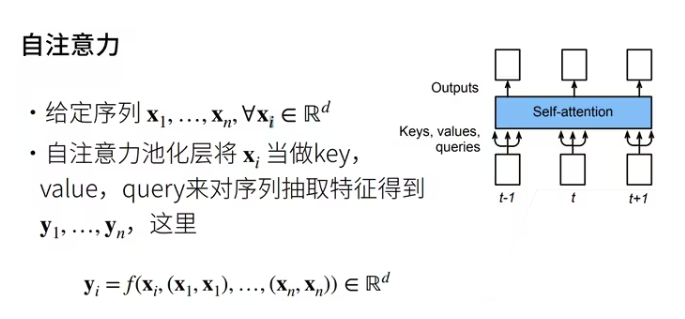
有了注意力机制之后，我们将词元序列输入注意力池化中， 以便同一组词元同时充当查询、键和值。 具体来说，每个查询都会关注所有的键－值对并生成一个注意力输出

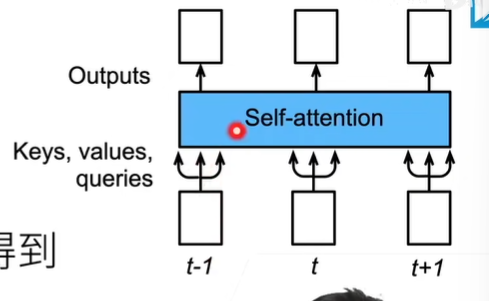

t时刻的x作为K,v,q

对于 key 、value 和 query ，自注意力有自己的一套选法，因为 key 、value 和 query 的值来自同一组输入，因此被称为自注意力（self-attention）或者内部注意力（intra-attention）

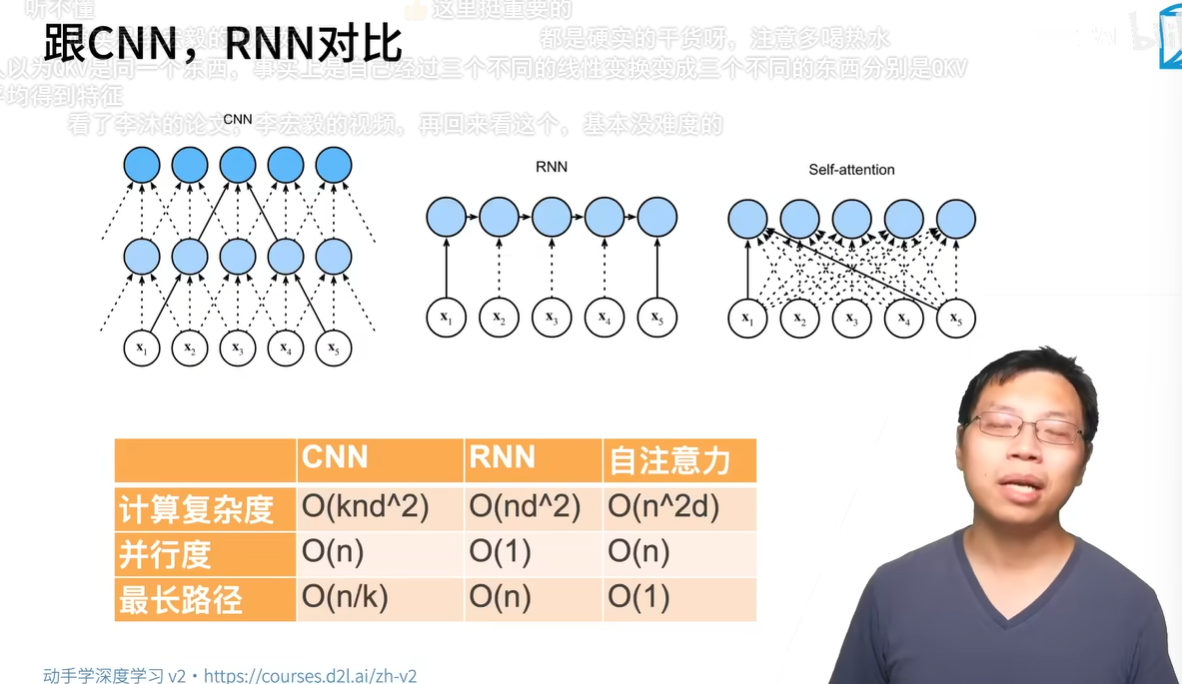

给定序列是一个长为 n 的序列，每个 xi 是一个长为 d 的向量
自注意力将 xi 同时作为 key 、value 和 query ，以此来对序列抽取特征
基本上可以认为给定一个序列，会对序列中的每一个元素进行输出，也就是说，每个查询都会关注所有的键-值对并生成一个注意力输出
自注意力之所以叫做自注意力，是因为 key，value，query 都是来自于自身，xi 既作为 key ，又作为 value ，同时还作为 query （self-attention 中的 self 所强调的是  key，value，query 的取法）

CNN（卷积神经网络），RNN（循环神经网络）

CNN、RNN、自注意力都可以用来处理序列
CNN 如何处理序列：给定一个序列，将其看作是一个一维的输入（之前在处理图片时，图片具有高和宽，而且每个像素都具有 chanel 数，也就是特征数），如果用 CNN 做序列的话，经过一个 1d 的卷积（只有宽没有高）之后，将每个元素的特征看作是 channel 数，这样就可以用来处理文本序列了
k：窗口大小，每次看到的长度为 k
n：长度
d：dimension，每个 x 的维度（长度）
并行度：每个输出( yi )可以自己并行做运算，因为 GPU 有大量的并行单元，所以并行度越高，计算的速度就越快
最长路径：对于最长的那个序列，前面时刻的信息通过神经元传递到后面时刻,对应于计算机视觉中的感受野的概念（每一个神经元的输出对应的图片中的视野）
卷积神经网络和自注意力都拥有并行计算的优势，而且自注意力的最大路径长度最短。但是因为自注意力的计算复杂度是关于序列长度的二次方，所以在很长的序列中计算会非常慢




位置编码（position encoding）

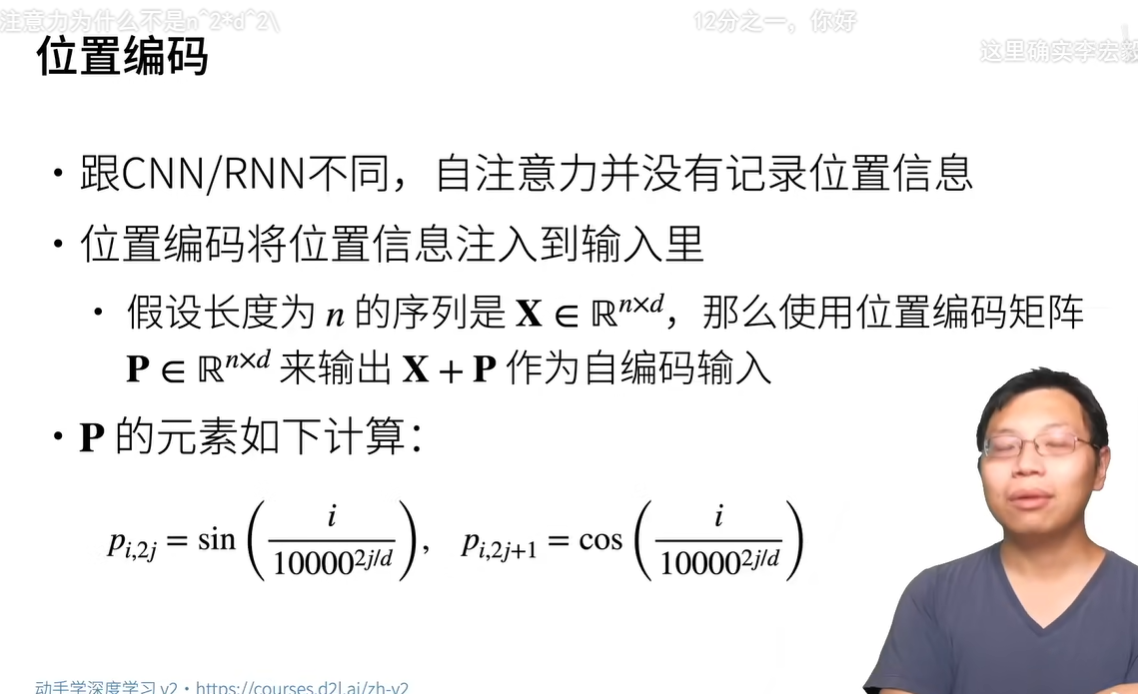

在处理词元序列时，循环神经网络是逐个的重复地处理词元的， 而自注意力则因为并行计算而放弃了顺序操作。 为了使用序列的顺序信息，通过在输入表示中添加 位置编码（positional encoding）来注入绝对的或相对的位置信息。 位置编码可以通过学习得到也可以直接固定得到

1、和 CNN / RNN 不同，自注意力并没有记录位置信息

CNN 中其实是有记录位置信息的，从输出可以反推出输入所在的窗口的位置，窗口大小可以看成是位置信息
RNN 本身就是序列相关的，它是通过逐个的重复地处理词元
对于自注意力来说，如果将输入进行随机打乱，对应输出的位置可能会发生变化，但是每个输出的内容不会发生变化
所以如果是想纯用自注意力机制来做序列模型的话，没有位置信息的话可能会出现问题，所以可以通过加入位置编码来加入位置信息

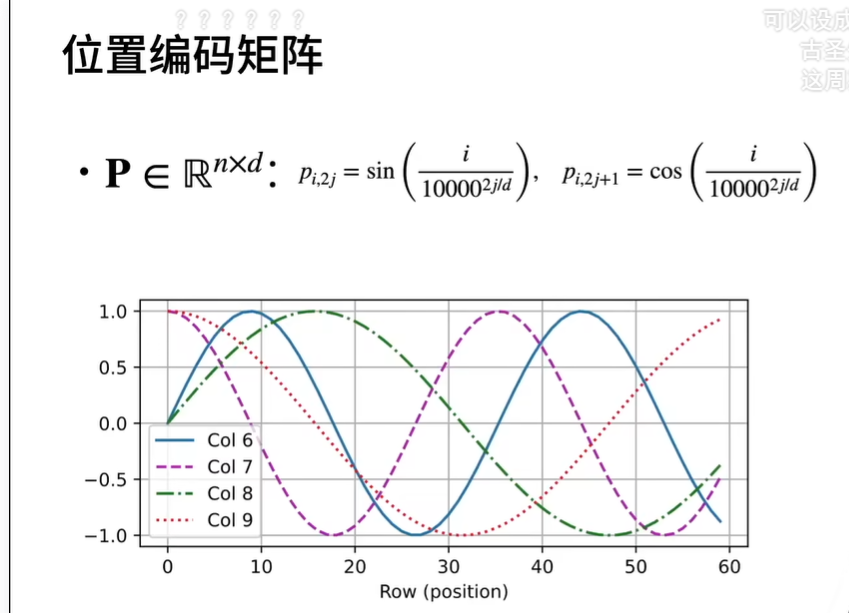、

# 绝对位置信息

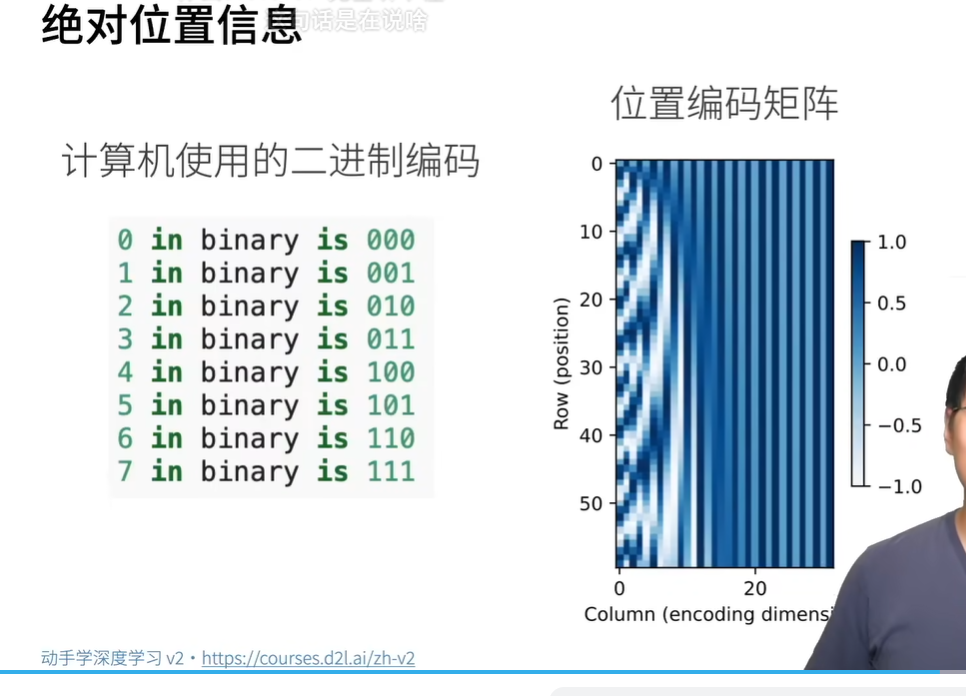

# 相对位置信息

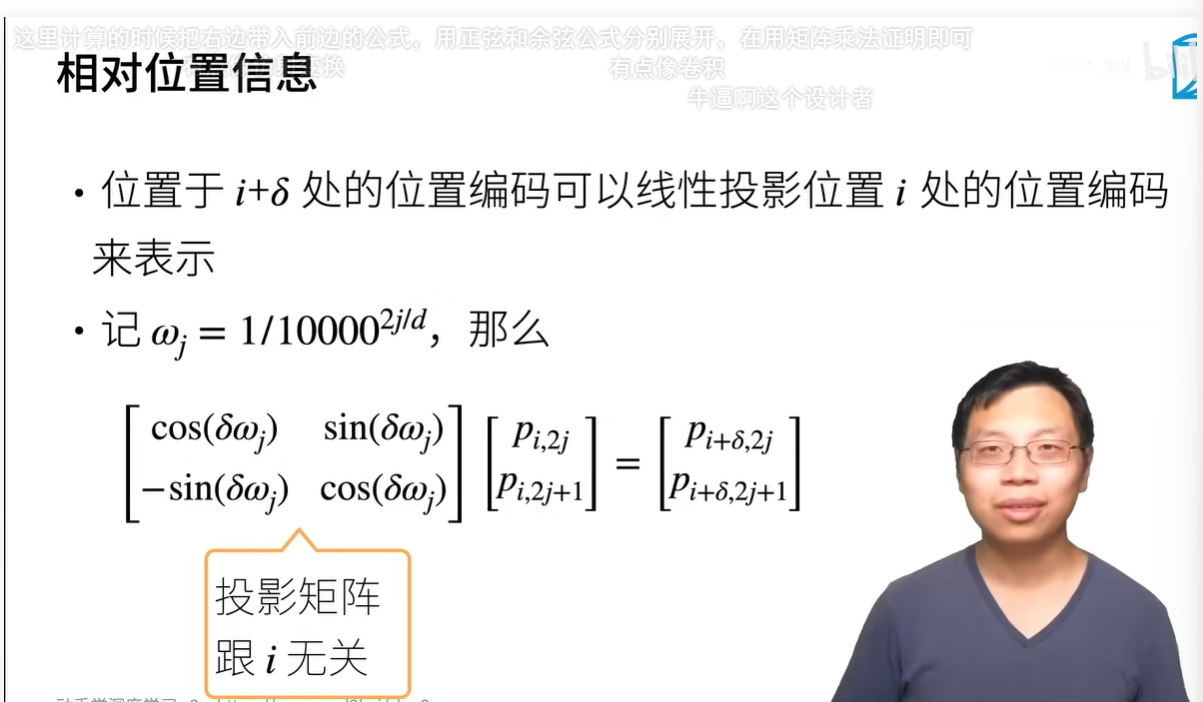

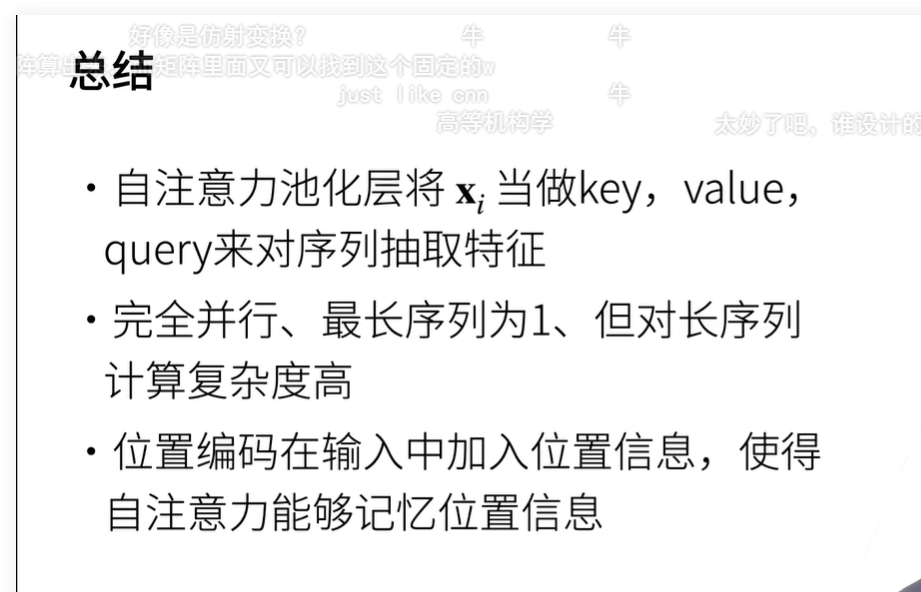

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 定义隐藏层的维度和注意力头的数量
num_hiddens, num_heads = 100, 5

# 创建一个多头注意力机制的实例
# 参数说明：
# - 第一个 num_hiddens：查询（queries）和键（keys）的特征维度
# - 第二个 num_hiddens：值（values）的特征维度
# - 第三个 num_hiddens：用于多头注意力机制的特征维度
# - 第四个 num_hiddens：输出特征维度
# - num_heads：注意力头的数量，表示我们希望学习多少个不同的注意力机制
# - 0.5：dropout比率，用于防止过拟合
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                   num_hiddens, num_heads, 0.5)

# 将注意力机制设置为评估模式，禁用训练期间的机制（如 dropout）
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [3]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

In [4]:
# 位置编码

# @save 指令表示在使用 d2l 库时，将此类保存到文件中
class PositionalEncoding(nn.Module):
    """位置编码"""
    
    def __init__(self, num_hiddens, dropout, max_len=1000):
        """初始化位置编码
        
        参数:
        - num_hiddens: 嵌入维度或隐藏层维度
        - dropout: dropout比率
        - max_len: 位置编码的最大长度，默认值为 1000
        """
        super(PositionalEncoding, self).__init__()
        # 初始化 dropout 层
        self.dropout = nn.Dropout(dropout)
        
        # 创建一个足够长的P，以存储位置编码
        self.P = torch.zeros((1, max_len, num_hiddens))

        # 生成位置编码
        # X 为位置序列，形状为 (max_len, 1)
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(
            10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens
        )

        # 使用正弦和余弦函数填充 P 的偶数维度（0, 2, 4, ...）
        self.P[:, :, 0::2] = torch.sin(X)
        
        # 使用正弦和余弦函数填充 P 的奇数维度（1, 3, 5, ...）
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        """前向传播方法
        
        参数:
        - X: 输入张量，形状为 (batch_size, seq_len, num_hiddens)
        
        返回:
        - 添加了位置编码的输出张量
        """
        # 将输入张量 X 加上对应的 P 值，位置编码
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        
        # 应用 dropout，并返回结果
        return self.dropout(X)

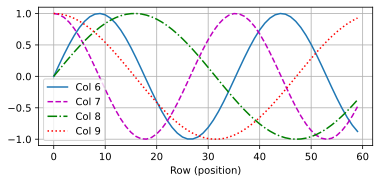

In [5]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

In [6]:
for i in range(8):
    print(f'{i}的二进制是：{i:>03b}')

0的二进制是：000
1的二进制是：001
2的二进制是：010
3的二进制是：011
4的二进制是：100
5的二进制是：101
6的二进制是：110
7的二进制是：111


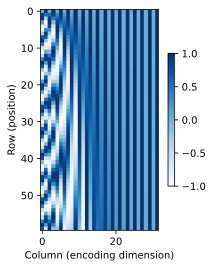

In [7]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

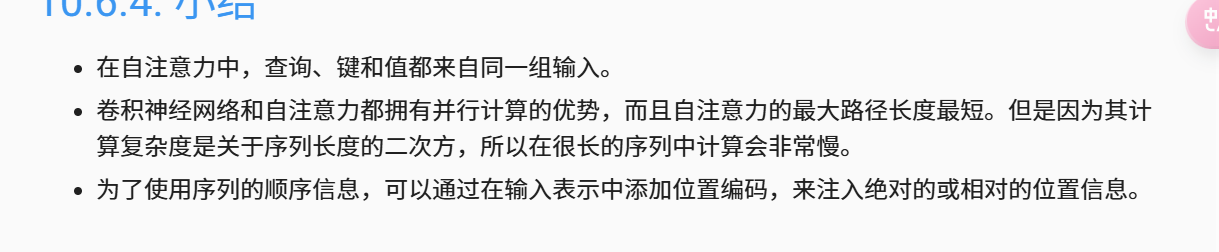